In [32]:
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pytorch_lightning as pl
from glob import glob

In [13]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")
from srsphere.models.Unet import Unet
from srsphere.models.ddpm import DDPM
from srsphere.diffusion.scheduler import TimestepSampler
from srsphere.dataset.datamodules import DataModule
from srsphere.dataset.fits_dataset import MapDataset
from srsphere.generation.gen_strategy import GenerationStrategy

from srsphere.params import set_params
from train import setup_trainer

In [3]:
params = set_params(
        n_maps=1,
        nside=512,
        order=8,
        batch_size=4,
        difference=True,
        conditioning="concat",
        norm_type="batch",
        act_type="silu",
        use_attn=False,
        mask=False,
        scheduler="linear",
        timesteps=2000,
        log_name="test",
        )

In [8]:
## get training data
dm = DataModule(**params['data'])
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

loading 1 maps in the directory.
LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256.  Number of maps: 1
data divided into 768 patches.
train:validation:test = 614:76:78, batch_size: 4


In [9]:
#get sampler type
sampler = TimestepSampler(timesteps=params['diffusion']['timesteps'])

sampler type: uniform, timesteps: 2000


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
unet = Unet(params['data']["nside"], params['data']["order"], **params['architecture'])
model = DDPM(unet, sampler, **params['diffusion']).to(device)

The schedule is linear with beta_start = 1e-06, beta_end = 0.01


In [11]:
# for demo
params["train"]["n_epochs"] = 1

trainer = setup_trainer(**params['train'])
trainer.fit(model, train_loader, val_loader)

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


data saved in /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/ckpt_logs
data name: test


/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
Missing logger folder: /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/ckpt_logs/test
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 65.9 M
-------------------------------
65.9 M    Trainable params
0         Non-trainable params
65.9 M    Total params
263.422   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 173/173 [03:44<00:00,  1.30s/it, loss=0.0328, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 173/173 [03:49<00:00,  1.33s/it, loss=0.0328, v_num=0]


In [12]:
model = model.to(device)
model.eval()

DDPM(
  (model): Unet(
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=64, out_features=64, bias=True)
    )
    (init_conv): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (down_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (emb): TimeEmbed(
            (proj): Linear(in_features=64, out_features=128, bias=True)
            (act): SiLU()
          )
          (in_layers): Sequential(
            (0): Norms(
              (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): Acts(
              (act): SiLU()
            )
            (2): SphericalChebConv(
              (chebconv): ChebConv()
            )
          )
          (pooling): Identity()
          (out_layers): Sequential(
            (0): Norms(
              (

In [22]:
# for validation
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
ckpt_dir = f"{base_dir}/ckpt_logs/test/version_0"
params['valid'] = {}
params['valid']['save_dir'] = f"{base_dir}/results/imgs/diffusion/{ckpt_dir.split('/')[-2]}"
os.makedirs(params['valid']['save_dir'], exist_ok=True)
params['valid']['timesteps'] = 1200

In [34]:
dataset = MapDataset(lrdir=params['data']['LR_dir'], hrdir=params['data']['HR_dir'], n_maps=1, norm=params['data']['norm'], order=None, difference=params['data']['difference'], upsample_scale=params['data']['upsample_scale']**3)
cond = dataset.lrmaps[0].reshape(-1)
strategy = GenerationStrategy(model, params['data']["nside"], params['data']["order"], params['valid'], cond)

loading 1 maps in the directory.
LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256.  Number of maps: 1


In [35]:
sample = dm.dataset.__getitem__(0)
condition = sample[0].unsqueeze(0).to(device)

Diffusion: 100%|██████████| 1200/1200 [05:36<00:00,  3.57it/s]


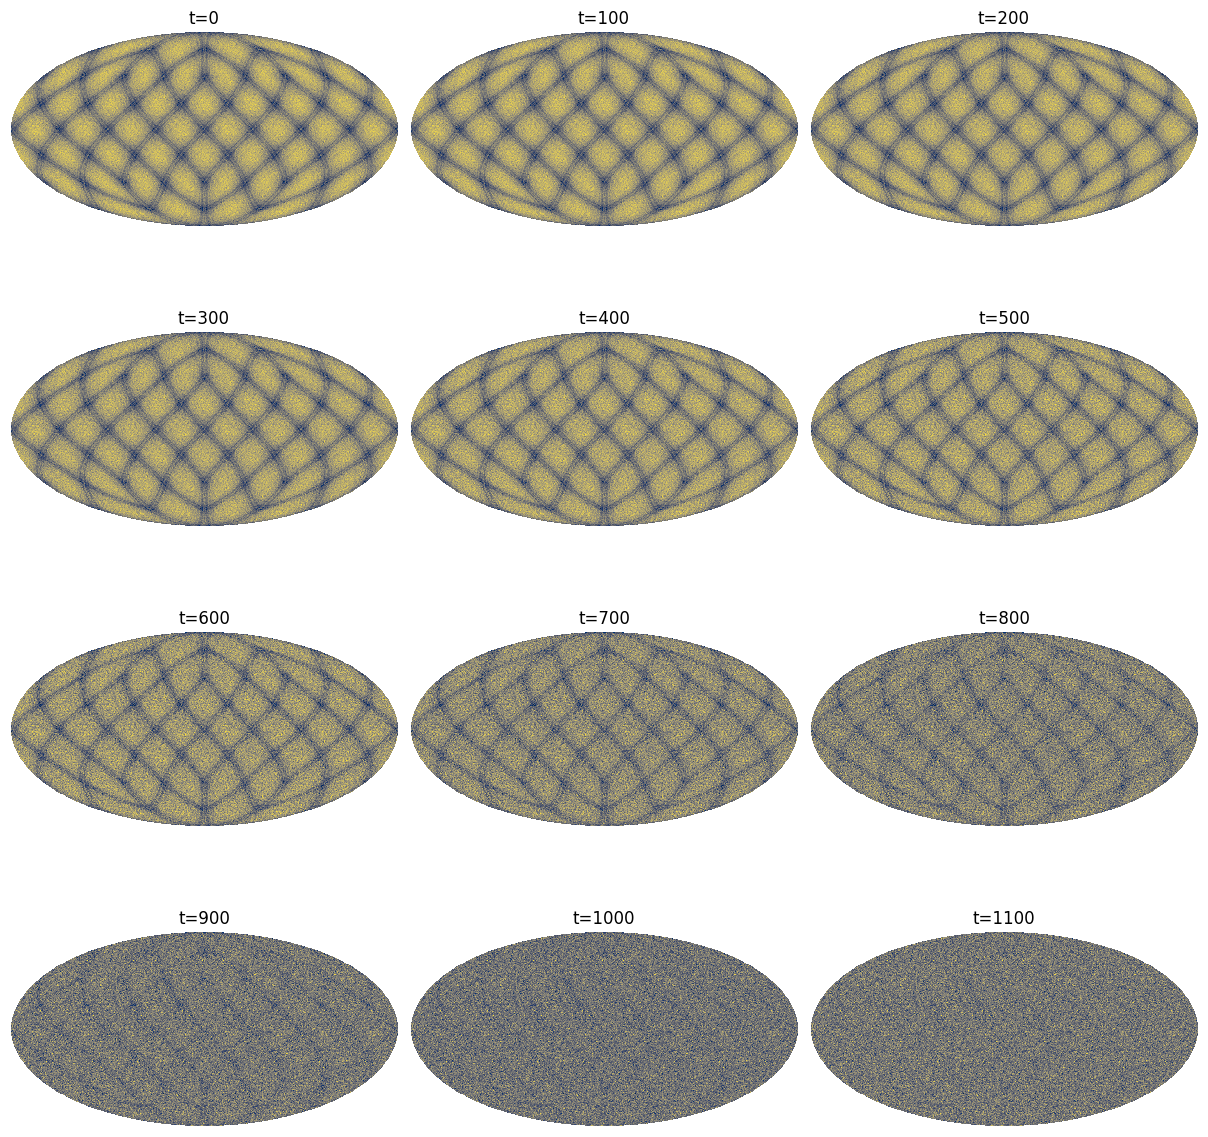

In [47]:
y = torch.randn(condition.shape, device=condition.device)
fig = plt.figure(figsize=(12, 12))
with torch.no_grad():
    for j in tqdm(reversed(range(0, strategy.timesteps)), desc="Diffusion", total=strategy.timesteps):
        t = torch.full((y.shape[0],), j, device=y.device, dtype=torch.long)
        y = model.diffusion.p_sample(model.model, y, t, t_index=j, condition=condition)
        if j % 100 == 0:
            hp.mollview(np.hstack([y.cpu().squeeze().numpy() for _ in range(48)]), title=f"t={j}", sub=(4, 3, j//100+1), fig=fig, cbar=False, nest=True, cmap="cividis")